In [1]:
import os
import glob
import itertools
import json
import importlib
import copy

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

In [35]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.correlations as cr
import analyze2p.scatter as sct

In [3]:
%matplotlib notebook

In [4]:
# import sys
# !{sys.executable} -m pip install shapely

# Source data

In [5]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

## Select data and output

In [7]:
# experiment = 'rfs'
response_type='dff'
do_spherical_correction=False
# ---------------------------------------------------------------
responsive_test=None
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
data_id = '|'.join([traceid, rf_fit_desc])
rf_type = 'rfs_sphrcorr' if do_spherical_correction else 'rfs_uncorr'
print(data_id)
# Set output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', '%s_metrics' % rf_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

traces001|fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_uncorr_metrics


## Metdata

In [8]:
# Load RF fit params for good rois
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
|    |   visual_area |
|:---|--------------:|
| V1 |            18 |
| Li |            15 |
| Lm |            15 |


## Load RF fits

In [30]:
# Load fits
# rfdata = rfutils.aggregate_rfdata(meta, CELLS, fit_desc=rf_fit_desc)
# print(rfdata['experiment'].unique())
rfdf = rfutils.aggregate_fits(CELLS,meta,
                        response_type=response_type,
                        do_spherical_correction=do_spherical_correction,
                        reliable_only=True, pass_criterion=['position', 'size'], 
                        combine='select', ecc_center=(0, 20))
# Add ROI positions
rfdf = aggr.add_roi_positions(rfdf.copy())
# rf_counts_all = aggr.count_n_cells(rfdf)
# rf_counts_all.groupby('visual_area').sum()

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


,n_cells
visual_area,
Li,418
Lm,331
V1,615


In [163]:
# Combine rf5, rf10
# GRFS, rf_counts = rfutils.merge_rf_experiments(rfdata)

## Add projection and scatter info

In [104]:
ecc_center=(0, 20)
no_rfs=[]; bad_fits=[];
a_list=[]
for (va, dk, exp), g in rfdf.groupby(['visual_area', 'datakey', 'experiment']):
    regr_np = sct.load_models(dk, va)
    aligned_ = sct.predict_soma_from_gradient(dk, va, regr_np, experiment=exp,
                                response_type=response_type,ecc_center=ecc_center,
                                do_spherical_correction=do_spherical_correction)
#     aligned_ = sct.project_soma_position_in_fov(dk, va, experiment=exp,
#                                 response_type=response_type,
#                                 do_spherical_correction=do_spherical_correction)
    if (regr_np['R2']<0.5).values.all():
        bad_fits.append((va, dk, exp))
        continue
    if aligned_ is None:
        no_rfs.append((va, dk, exp))
        continue
    for p in ['R2', 'RMSE', 'coefficient', 'intercept']:
        r2_ml = float(regr_np[regr_np.cond=='az'][p])
        r2_ap = float(regr_np[regr_np.cond=='el'][p])
        aligned_['gradient_%s_ml' % p] = r2_ml
        aligned_['gradient_%s_ap' % p] = r2_ap
    
    aligned_['visual_area']==va
    aligned_['datakey'] = dk
    aligned_['experiment'] = exp
    a_list.append(aligned_)
aligned_soma = pd.concat(a_list, axis=0, ignore_index=True)
aligned_soma.head()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,dist_scatter_ap,inbounds,gradient_R2_ml,gradient_R2_ap,gradient_RMSE_ml,gradient_RMSE_ap,gradient_coefficient_ml,gradient_coefficient_ap,gradient_intercept_ml,gradient_intercept_ap
0,27.756791,19.366844,56.311148,32.496182,0.781535,-0.007241,0.067907,0.539045,23.962191,13.828163,...,711.549647,True,0.69388,0.904281,4.797599,1.175004,0.076593,0.023525,-29.111151,-0.968611
1,12.547553,2.575408,29.483279,25.960254,6.261076,0.001269,-0.061413,0.529471,12.546076,11.046917,...,6.640830,True,0.69388,0.904281,4.797599,1.175004,0.076593,0.023525,-29.111151,-0.968611
2,3.718242,11.808561,31.775268,30.710660,0.442564,-0.002772,0.105059,0.767423,13.521391,13.068366,...,283.116023,True,0.69388,0.904281,4.797599,1.175004,0.076593,0.023525,-29.111151,-0.968611
3,13.605638,20.419131,59.865185,26.799962,0.355858,-0.003917,0.080505,0.587964,25.474547,11.404239,...,593.356775,True,0.69388,0.904281,4.797599,1.175004,0.076593,0.023525,-29.111151,-0.968611
4,8.476630,2.498789,38.655483,25.170942,0.701064,-0.000826,0.057451,0.515310,16.449142,10.711039,...,9.849549,True,0.69388,0.904281,4.797599,1.175004,0.076593,0.023525,-29.111151,-0.968611


In [105]:
bad_fits

[('V1', '20190504_JC078_fov1', 'rfs'), ('V1', '20190512_JC083_fov1', 'rfs')]

In [106]:
no_rfs 

[]

In [107]:
rf_counts_all = aggr.count_n_cells(aligned_soma)
rf_counts_all.groupby('visual_area').sum()

,n_cells
visual_area,
Li,575
Lm,366
V1,641


In [108]:
dk='20191006_JC110_fov1'
va='V1'
regr_np = sct.load_models(dk, va)
regr_np

,R2,RMSE,pearson_p,pearson_r,coefficient,intercept,cond,aligned
0,0.624337,3.594858,8.827261e-73,0.790150,0.021267,21.993912,az,True
1,0.462352,3.749262,8.597404e-47,0.679965,0.013432,-15.866369,el,True


#### Drop repeat FOVs

In [109]:
# Drop repeats -- this combines 5 and 10...
rf_ukeys = aggr.drop_repeats(rf_counts_all, colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in aligned_soma.groupby(['visual_area', 'datakey'])
                  if (va, dk) in rf_ukeys])
final_counts = aggr.count_n_cells(finaldf)
final_counts.groupby('visual_area').sum()

[V1] Animalid does not exist: JC078 


,n_cells
visual_area,
Li,379
Lm,229
V1,555


<IPython.core.display.Javascript object>


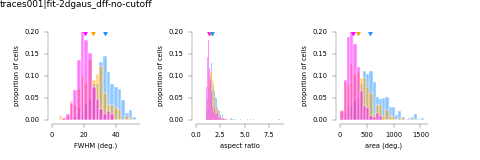

No handles with labels found to put in legend.


fwhm_avg                                                        \
               count       mean       std        min        25%        50%   
visual_area                                                                  
Li             379.0  33.294438  7.590673  14.186013  28.380541  33.015422   
Lm             229.0  25.808386  7.976604   4.192896  19.962565  25.441415   
V1             555.0  21.320394  5.373961   7.753588  17.994567  20.780352   

                                  aspect_ratio            ...            \
                   75%        max        count      mean  ...       75%   
visual_area                                               ...             
Li           38.333295  52.820103        379.0  1.812727  ...  1.990837   
Lm           30.859410  48.955025        229.0  1.635796  ...  1.772155   
V1           24.082068  38.785655        555.0  1.427571  ...  1.527364   

                        area                                                 \
                  max  count        mean         std        min         25%   
visual_area                                                                   
Li           8.675383  379.0  610.914801  280.725576  77.529152  432.946963   
Lm           4.119268  229.0  390.161546  232.460762   9.030843  215.083713   
V1           3.568268  555.0  264.338898  133.618842  33.913805  176.212724   

                                                  
                    50%         75%          max  
visual_area                                       
Li           567.515025  762.877605  1565.608267  
Lm           342.975316  516.874781  1347.108976  
V1           235.956799  321.941449   785.081282  

[3 rows x 24 columns]

In [110]:
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()

plot_params = ['fwhm_avg', 'aspect_ratio', 'area']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'area': 'area (deg.)'}
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))

ylim=0.2
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=finaldf, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25)
sns.despine(offset=4)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

finaldf.groupby(['visual_area'])[plot_params].describe()

In [111]:
import analyze2p.objects.sim_utils as su

In [52]:
print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

fit-2dgaus_dff-no-cutoff


<IPython.core.display.Javascript object>


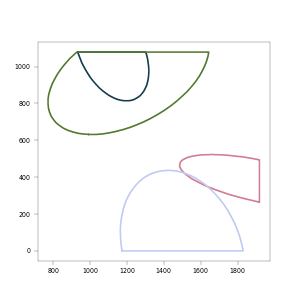

20190430_JC078_fov1
20190522_JC089_fov1
20190622_JC085_fov1
20191017_JC113_fov1


In [28]:
%matplotlib notebook
fig, ax = pl.subplots(figsize=(4,4))
col_list = sns.color_palette('cubehelix', n_colors=len(check_rfs))
for col, (dk, check_r) in zip(col_list, check_rfs.items()):
    print(dk)
    for rid, poly1 in check_r:
        ax.plot(*poly1.exterior.xy, color=col)
ax.set_aspect('equal')

In [116]:
def combined_axis_colum_names(x_cols):

    name_lut={}
    for name in x_cols:
        if  'scatter' in name or 'gradient' in name:
            if '0' in name:
                new_name = name.split('_x0')[0] if 'x0' in name \
                            else name.split('_y0')[0] 
            else:
                new_name = name.split('_ml')[0] if 'ml' in name \
                            else name.split('_ap')[0] 
        elif 'x0' in name or 'y0' in name:
            new_name = name.replace('x0', 'rf_pos') if 'x0' in name \
                            else name.replace('y0', 'rf_pos')
        elif 'x' in name or 'y' in name:
            new_name = name.split('_x')[0] if 'x' in name \
                            else name.split('_y')[0] 
        elif 'ml' in name or 'ap' in name:
            new_name = name.replace('ml', 'ctx') if 'ml' in name \
                            else name.replace('ap', 'ctx')
        name_lut.update({name: new_name})
    return name_lut
    

In [117]:
finaldf.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy',
       'theta_c', 'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy',
       'theta_Mm_c', 'aniso_index', 'eccentricity', 'eccentricity_ctr',
       'rf_theta_deg', 'aspect_ratio', 'cell', 'visual_area', 'datakey',
       'experiment', 'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix',
       'fov_ypos', 'fov_ypos_pix', 'ml_pos', 'ap_pos', 'ml_proj', 'ap_proj',
       'predicted_ml_proj', 'predicted_ap_proj', 'predicted_x0',
       'predicted_y0', 'predicted_ml_pos', 'predicted_ap_pos',
       'deg_scatter_x0', 'deg_scatter_y0', 'dist_scatter_ml',
       'dist_scatter_ap', 'inbounds', 'gradient_R2_ml', 'gradient_R2_ap',
       'gradient_RMSE_ml', 'gradient_RMSE_ap', 'gradient_coefficient_ml',
       'gradient_coefficient_ap', 'gradient_intercept_ml',
       'gradient_intercept_ap'],
      dtype='object')

In [118]:
ignore_cols = ['fov_xpos', 'fov_ypos', 'fov_xpos_pix', 'fov_ypos_pix']
non_cond_cols = ['experiment', 'visual_area', 'datakey', 'cell', 'r2',
                'theta', 'offset', 'amplitude', 'inbounds', 'aniso_index',
                'ratio_xy', 'major_axis', 'minor_axis', 'anisotropy', 
                'eccentricity', 'eccentricity_ctr']
soma = finaldf.rename(columns={'fx': 'vectorproj_x', 'fy': 'vectorproj_y'})
x_cols = [c for c in soma.columns if ('x' in c or 'ml' in c) \
              and (c not in non_cond_cols) and (c not in ignore_cols)]
y_cols = [c for c in soma.columns if ('y' in c or 'ap' in c) \
              and (c not in non_cond_cols) and (c not in ignore_cols)]

In [119]:
curr_cols = non_cond_cols.copy()
curr_cols.extend(x_cols)
name_lut_x =  combined_axis_colum_names(x_cols)
x_df = soma[curr_cols].rename(columns=name_lut_x)
x_df['axis'] = 'az'

curr_cols = non_cond_cols.copy()
curr_cols.extend(y_cols)
name_lut_y =  combined_axis_colum_names(y_cols)
y_df = soma[curr_cols].rename(columns=name_lut_y)
y_df['axis'] = 'el'

In [120]:
name_lut_x

{'x0': 'rf_pos',
 'fwhm_x': 'fwhm',
 'std_x': 'std',
 'vectorproj_x': 'vectorproj',
 'ml_pos': 'ctx_pos',
 'ml_proj': 'ctx_proj',
 'predicted_ml_proj': 'predicted_ctx_proj',
 'predicted_x0': 'predicted_rf_pos',
 'predicted_ml_pos': 'predicted_ctx_pos',
 'deg_scatter_x0': 'deg_scatter',
 'dist_scatter_ml': 'dist_scatter',
 'gradient_R2_ml': 'gradient_R2',
 'gradient_RMSE_ml': 'gradient_RMSE',
 'gradient_coefficient_ml': 'gradient_coefficient',
 'gradient_intercept_ml': 'gradient_intercept'}

In [121]:
projdf = pd.concat([x_df, y_df], axis=0, ignore_index=True)
projdf.head()

,experiment,visual_area,datakey,cell,r2,theta,offset,amplitude,inbounds,aniso_index,...,predicted_ctx_proj,predicted_rf_pos,predicted_ctx_pos,deg_scatter,dist_scatter,gradient_R2,gradient_RMSE,gradient_coefficient,gradient_intercept,axis
0,rfs10,Li,20190522_JC089_fov1,112,0.539045,0.781535,-0.007241,0.067907,True,0.109609,...,742.468283,9.455026,-3.021322,18.301764,238.947976,0.69388,4.797599,0.076593,-29.111151,az
1,rfs10,Li,20190522_JC089_fov1,113,0.529471,6.261076,0.001269,-0.061413,True,-0.060733,...,543.896362,11.278964,275.669620,1.268589,16.562709,0.69388,4.797599,0.076593,-29.111151,az
2,rfs10,Li,20190522_JC089_fov1,116,0.767423,0.442564,-0.002772,0.105059,True,-0.002445,...,428.620805,7.355988,-27.143673,-3.637746,47.494442,0.69388,4.797599,0.076593,-29.111151,az
3,rfs10,Li,20190522_JC089_fov1,121,0.587964,0.355858,-0.003917,0.080505,True,-0.115683,...,557.710724,7.546800,-151.888684,6.058838,79.104232,0.69388,4.797599,0.076593,-29.111151,az
4,rfs10,Li,20190522_JC089_fov1,145,0.515310,0.701064,-0.000826,0.057451,True,0.061281,...,490.746363,2.741541,242.129339,5.735089,74.877368,0.69388,4.797599,0.076593,-29.111151,az


In [122]:
projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()
projdf['dist_scatter_abs'] = projdf['dist_scatter'].abs()

In [123]:
az_min, az_max = (-60, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)

# df = projdf.copy()
# df = cr.cut_bins(df, x_bins, 'x0')

In [172]:
df_ = df[(df.visual_area==va) & (df.datakey==dk)].copy()

In [173]:
df_.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'cell', 'datakey', 'visual_area', 'experiment', 'std_x', 'std_y',
       'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy', 'theta_c',
       'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy', 'theta_Mm_c',
       'aniso_index', 'rf_theta_deg', 'aspect_ratio', 'eccentricity',
       'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix', 'fov_ypos',
       'fov_ypos_pix', 'ml_pos', 'ap_pos', 'binned_x0', 'x0_label'],
      dtype='object')

In [174]:
x_var = 'x0_label'
meanr = df.groupby(['visual_area', 'datakey', x_var]).mean().reset_index()

<IPython.core.display.Javascript object>


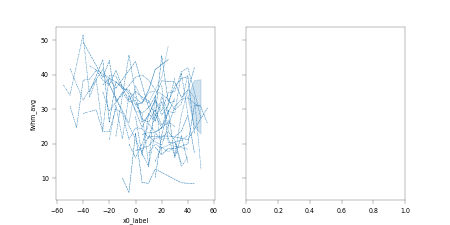

In [175]:
fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=False, sharey=True)

plotd = meanr[(meanr.visual_area=='V1')]
ax=axn[0]
sns.lineplot(x=x_var, y='fwhm_avg', style='datakey', data=meanr, ax=ax,
            lw=0.5)
ax.legend_.remove()
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[0]
# sns.scatterplot(x='x0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)

In [317]:
soma.columns

Index(['x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset', 'amplitude', 'r2',
       'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area', 'fx', 'fy', 'ratio_xy',
       'theta_c', 'theta_Mm_deg', 'major_axis', 'minor_axis', 'anisotropy',
       'theta_Mm_c', 'aniso_index', 'eccentricity', 'rf_theta_deg',
       'aspect_ratio', 'cell', 'visual_area', 'datakey', 'experiment',
       'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix', 'fov_ypos',
       'fov_ypos_pix', 'ml_pos', 'ap_pos', 'ml_proj', 'ap_proj',
       'predicted_ml_proj', 'predicted_ap_proj', 'predicted_x0',
       'predicted_y0', 'predicted_ml_pos', 'predicted_ap_pos',
       'deg_scatter_x0', 'deg_scatter_y0', 'dist_scatter_ml',
       'dist_scatter_ap', 'inbounds'],
      dtype='object')

In [68]:
axis_colors={'az': 'blue', #[0.7]*3,
             'el': 'orange'} #[0.5]*3}

<IPython.core.display.Javascript object>


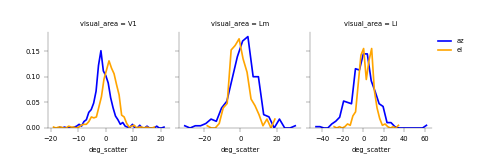

<IPython.core.display.Javascript object>


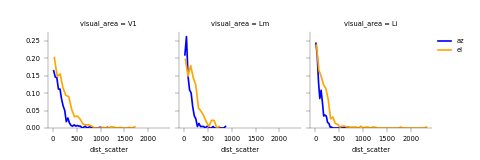

In [124]:
x_var = 'deg_scatter'
%matplotlib notebook
plot_cdf=False
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   #row='experiment', row_order=['rfs', 'rfs10'],
                  data=projdf, hue='axis', palette=axis_colors, height=2,
                  sharex=False)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=projdf, hue='axis', palette=axis_colors, height=2)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

## Greater scatter with eccentricity?

In [125]:
az_min, az_max = (0, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)

df = projdf.copy()
df = cr.cut_bins(df, x_bins, 'eccentricity')
df = cr.cut_bins(df, x_bins, 'eccentricity_ctr')

<IPython.core.display.Javascript object>


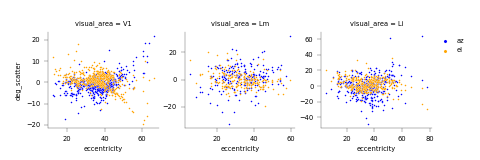

In [126]:

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, 'eccentricity', 'deg_scatter', s=2)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
#sns.scatterplot(x='rf_pos', y='deg_scatter', ax=ax, data=projdf)

<IPython.core.display.Javascript object>


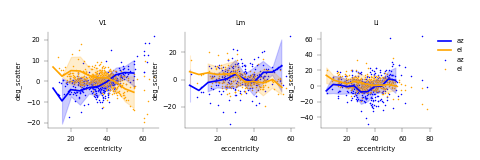

In [127]:
y_var='deg_scatter'
dist_var = 'eccentricity'
scatter_kws = {'size': 2}
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    plotd = binned_df[binned_df.visual_area==ax.title.get_text()].copy()
    sns.lineplot(x=x_var, y=y_var, hue='axis', data=plotd, ax=ax,
                palette=axis_colors, ci='sd')
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()
#     sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
#                  color='k',  ci='sd')

<IPython.core.display.Javascript object>


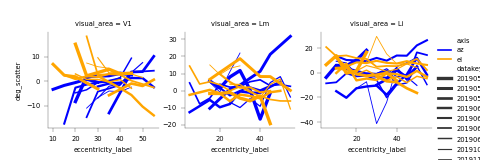

In [128]:
x_var='eccentricity_label'
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var])\
              .mean().reset_index()
plotd = binned_df.copy()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=plotd, height=2,
                  sharex=False, sharey=False)
fg.map(sns.lineplot, x_var, 'deg_scatter', 'axis', 'datakey',
       hue='axis', palette=axis_colors) #, scatter_kws=scatter_kws)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

## RF size ("CMF" for single-cell) vs. eccentricity?

<IPython.core.display.Javascript object>


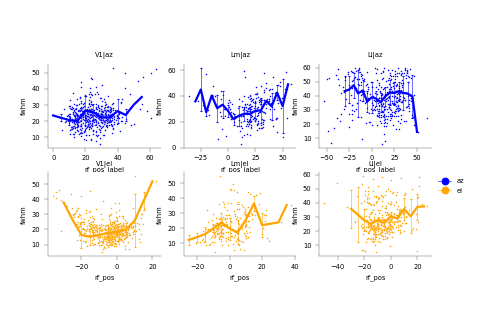

In [129]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
dist_var='rf_pos'
az_min, az_max = (-30, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)
df = projdf.copy()
df = cr.cut_bins(df, x_bins, dist_var)
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                   row='axis',
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}|{row_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    va, cnd = ax.title.get_text().split('|')
    plotd = binned_df[(binned_df.visual_area==va) & (binned_df.axis==cnd)].copy()
    sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
                 hue='axis', palette=axis_colors, 
                 ci='sd', err_style='bars',
                 lw=2, err_kws={'elinewidth':0.5, 'capsize':0.5})
    ax.legend_.remove()
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


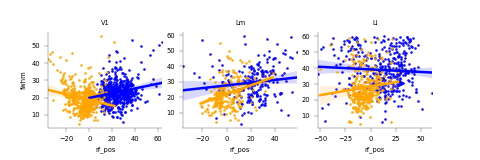

<IPython.core.display.Javascript object>


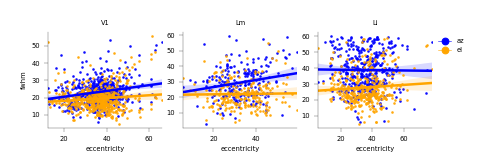

In [133]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
x_var='rf_pos'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='eccentricity'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


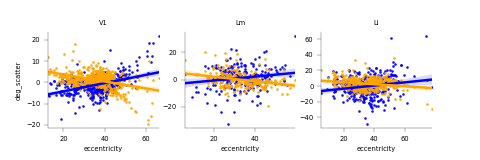

<IPython.core.display.Javascript object>


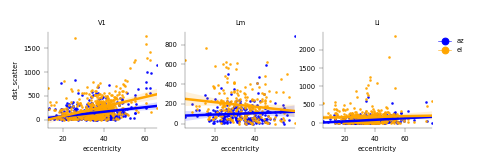

In [176]:
x_var = 'eccentricity'
y_var = 'deg_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var = 'eccentricity'
y_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

#legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

In [142]:
projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()

<IPython.core.display.Javascript object>


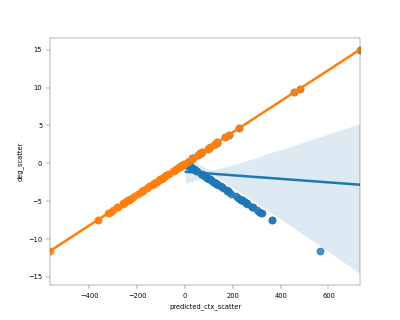

<AxesSubplot:xlabel='predicted_ctx_scatter', ylabel='deg_scatter'>

In [168]:
x_var = 'dist_scatter'
y_var = 'deg_scatter'
va='V1'
dk='20190617_JC097_fov1'
df_ = projdf[(projdf.visual_area==va) & (projdf.datakey==dk)].copy()

axd = df_[df_.axis=='az']
coef_ = float(axd['gradient_coefficient'].unique())
axd['predicted_deg_scatter'] = axd['dist_scatter']*coef_
axd['predicted_ctx_scatter'] = axd['deg_scatter']/coef_

fig, ax = pl.subplots()
sns.regplot(x=x_var, y=y_var, data=axd, ax=ax, label='measured scatter')
sns.regplot(x='predicted_ctx_scatter', y='deg_scatter', data=axd, ax=ax)

In [148]:
coef_ = float(axd['gradient_coefficient'].unique())
pred_vf_scatter = axd['dist_scatter']*coef_

In [171]:
 axd['deg_scatter']/0.02

997     -84.037616
998    -105.128046
999    -101.803617
1000     97.566163
1001    101.303169
           ...    
1081   -157.017476
1082     11.482773
1083   -163.610800
1084   -289.464806
1085     -9.294794
Name: deg_scatter, Length: 89, dtype: float64

In [462]:
cnts_fov = pd.concat([pd.DataFrame({'visual_area': va,
               'datakey': dk, 
               'n_cells': len(g['cell'].unique())}, index=[i])\
              for i, ((va, dk), g) in enumerate(df.groupby(['visual_area', 'datakey']))])

for (va, dk), g in df.groupby(['visual_area', 'datakey']):
    df.loc[g.index, 'n_cells'] = len(g['cell'].unique()) #len(df[() & ()]['cell'].unique())
    
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()


<IPython.core.display.Javascript object>


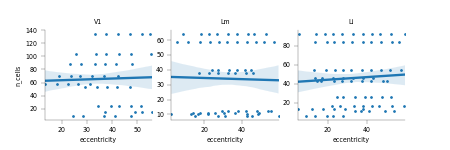

No handles with labels found to put in legend.


In [463]:
y_var = 'n_cells'
x_var =  dist_var # '%s_label' % dist_var
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=binned_df, palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.regplot, dist_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)


In [190]:
az_min, az_max = (-60, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)

df = soma.copy()
df = cr.cut_bins(df, x_bins, 'x0')

<IPython.core.display.Javascript object>


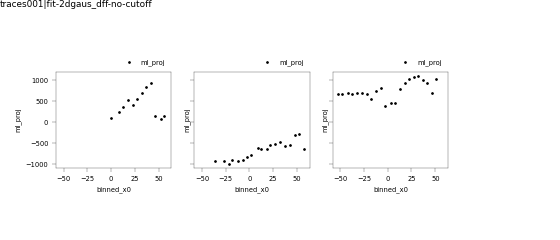

    val out of bounds
BINNED, no fit: Li
    val out of bounds
BINNED, no fit: Lm
    val out of bounds
BINNED, no fit: V1


In [191]:
%matplotlib notebook
n_iter=int(np.random.rand(1)[0]*500)
min_npairs = 10
dist_var = 'x0'
x_var = 'binned_%s' % dist_var
y_var = 'ml_proj' if dist_var=='x0' else 'ap_proj'
# ----------------------------------------------------
fit_sites = False
use_binned=False
fit_str = 'fitsites' if fit_sites else 'fitpairs'
dist_str = 'CTX' if dist_var=='cortical_distance' else 'RF'

xlabel=x_var
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
col_selector = ['visual_area', 'cell', dist_var, y_var] 
col_selector.extend(cnt_grouper)
# plot
fig, axn = pl.subplots(1,3, figsize=(7,3), sharex=True, sharey=True)
for va, vg in df.groupby('visual_area'):
    cc0 = vg[col_selector].copy()
    cnts = cc0.groupby(cnt_grouper)['cell'].count()  
#     # How many resample per group
#     nsamples_per = dict((k, v) for k, v \
#                         in zip(cnts[cnts>=min_npairs].index.tolist(),
#                                cnts[cnts>=min_npairs].values))
#     # Sample
#     cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
#                          for c, cg in cc0.groupby(cnt_grouper) \
#                          if c in nsamples_per.keys()])
    cc_ = cc0.copy()
    # fov mean for visualizing
    fov_cc = cc0[col_selector]\
                    .groupby(cnt_grouper).median().reset_index().dropna()
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index().dropna()
    ax=axn[visual_areas.index(va)]
    ax.scatter(x=dist_var, y=y_var, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median', metric=y_var,
                                            to_quartile=dist_var, return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    ax.set_ylabel(y_var)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=2)
    #ax.set_xlim([0, 250])
    #ax.set_ylim([-0.5, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)
#fig.text(0.01, 0.9, '%s: meds. per site @ each loc' % experiment, fontsize=8)

pplot.label_figure(fig, data_id)

# Aggregate RF comparisons

In [177]:
diffs = cr.aggregate_rf_dists(finaldf, rfpolys=rfpolys)

In [192]:
dist_var='cortical_distance'
ctx_maxdist=1200
ctx_step=25
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

rf_maxdist=120
rf_step=5
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)

dist_bins = copy.copy(ctx_bins) if dist_var=='cortical_distance' \
                else copy.copy(rf_bins)

diffs = cr.cut_bins(diffs, dist_bins, dist_var)

grp_step=100 if dist_var=='cortical_distance' else 15
grp_max = 1000 if dist_var=='cortical_distance' else 60
grp_bins = np.arange(0, grp_max+grp_step, grp_step)
diffs['group_value'] = pd.cut(diffs[dist_var], grp_bins, 
                            include_lowest=True, labels=grp_bins[0:-1])
diffs['group_label'] = [int(d) if not np.isnan(d) else d \
                             for d in diffs['group_value'].values]

cortical_distance_label


<IPython.core.display.Javascript object>


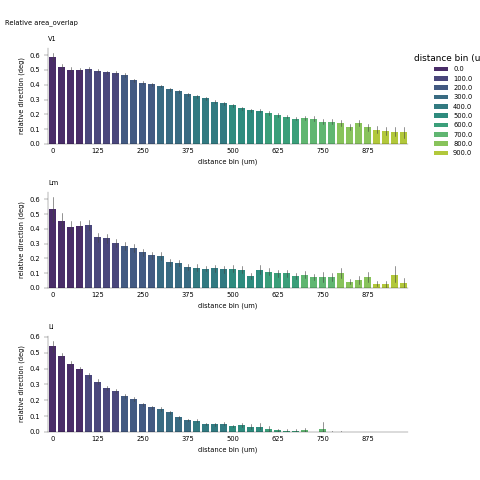

Text(0.01, 0.95, 'Relative area_overlap')

In [193]:
y_var = 'area_overlap'
x_var='%s_label' % dist_var
print(x_var)
dist_unit = 'um' if dist_var=='cortical_distance' else 'rf_distance'
hue_label = 'group_label'
palette='viridis'
#ylim = (0, 120)
# Ticks
min_npairs=0 #10
max_dist = grp_max
sorted_x_vars = [k for k, v in diffs.groupby(x_var) if k<max_dist]
# Colors
vals_ = grp_bins[grp_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
grp_colors = dict((k, v) for k, v in zip(vals_, cols_))
# plot
plotd = diffs[(diffs.cortical_distance<=max_dist)].copy()
fg = sns.FacetGrid(data=plotd, row='visual_area', row_order=['V1', 'Lm', 'Li'],
                   height=2, aspect=3, sharex=False, sharey=False)
fg.map(sns.barplot, x_var, y_var, hue_label, palette=grp_colors,
      dodge=False, errwidth=0.5, order=sorted_x_vars)
fg.set_titles("{row_name}", loc='left')  # use this argument literally
for ax in fg.axes.flat:
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xlabel('distance bin (%s)' %dist_unit)
    ax.set_xticklabels([int(i) for i in sorted_x_vars])
#     ax.set_ylim(ylim)
#     ax.set_yticks(np.linspace(0, ylim[-1], 4))
    ax.set_ylabel('relative direction (deg)')
    ax.set_xticks(np.arange(0, len(sorted_x_vars)))
    ax.set_xticklabels([int(i) if i in sorted_x_vars[0::5] else '' \
                            for i in sorted_x_vars])
    ax.set_title('')
ax=fg.axes.flat[0]
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False, 
         title='distance bin (um)')
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.9, wspace=0.5, hspace=0.5)
fg.fig.text(0.01, 0.95, 'Relative %s' % y_var)

# pplot.label_figure(fg.fig, data_id)
# figname = '%s_by_hue_distbin' % y_var
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
# print(dst_dir, figname)

In [275]:
import pingouin as pg

In [277]:
experiment = 'rfs'
responsive_test='nstds'
trial_epoch='stimulus'
# ----------------------------------------------------------------
response_type='dff'
responsive_thr=7.0 if experiment=='rfs' else 10.
n_stds=2.5
n_bootstrap_iters=500
print(responsive_test, responsive_thr)
# Responsive params
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
#### Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
#### Output dir
cc_dir = os.path.join(aggregate_dir, 'correlations', 
                       '%s_%s_%s' % (experiment, response_type, responsive_test))
if not os.path.exists(cc_dir):
    os.makedirs(cc_dir)
print(cc_dir)

nstds 7.0
traces001|dff_responsive-nstds-thr7.00
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds


In [278]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in rf_ukeys], ignore_index=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl


In [282]:
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=rfdf,
                        SDF=None, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Dist: rf_distance
Skipping - (Lm, 20191111_JC117_fov1)
Skipping - (V1, 20191111_JC117_fov1)
0 datasets w wrong configs:
0 datasets w/out RF fits:


In [284]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,rf_distance,max_ecc,min_ecc,cortical_distance,visual_area,datakey,experiment,n_cells
0,128,134,0.105330,128_134,0.163725,NaN,NaN,NaN,269.840697,Li,20190522_JC089_fov1,rfs,18
1,128,135,-0.018229,128_135,0.007574,NaN,NaN,NaN,219.036726,Li,20190522_JC089_fov1,rfs,18
2,128,136,-0.067843,128_136,0.013769,NaN,NaN,NaN,208.781022,Li,20190522_JC089_fov1,rfs,18
3,128,137,0.403666,128_137,0.239217,NaN,NaN,NaN,114.552472,Li,20190522_JC089_fov1,rfs,18
4,128,140,0.207901,128_140,0.117713,NaN,NaN,NaN,643.305301,Li,20190522_JC089_fov1,rfs,18


In [285]:
CORRS.shape, CORRS.dropna().shape

((209776, 13), (41361, 13))

In [287]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
DF = pd.merge(diffs, CORRS, on=cc_cols, how='inner')

<IPython.core.display.Javascript object>


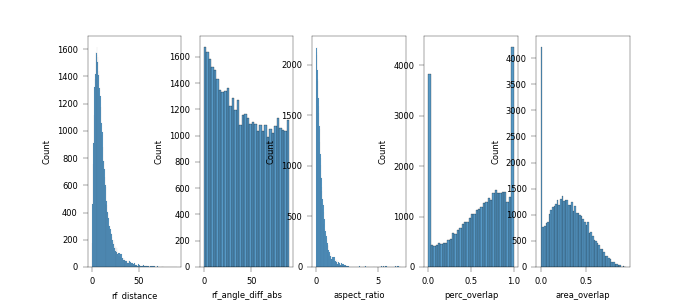

In [296]:
plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(1, len(plot_params), figsize=(7,3))
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=DF, ax=ax)

In [317]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [318]:
ctx_step=20
max_dist=1200
df = DF[DF.cortical_distance<=max_dist].copy()

ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

metric = 'rf_angle_diff_abs'
m_bins = np.linspace(0, 90, 13)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'aspect_ratio'
step = 0.5
m_bins = np.linspace(0, 3, 30)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'perc_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'area_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)


In [319]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

<IPython.core.display.Javascript object>


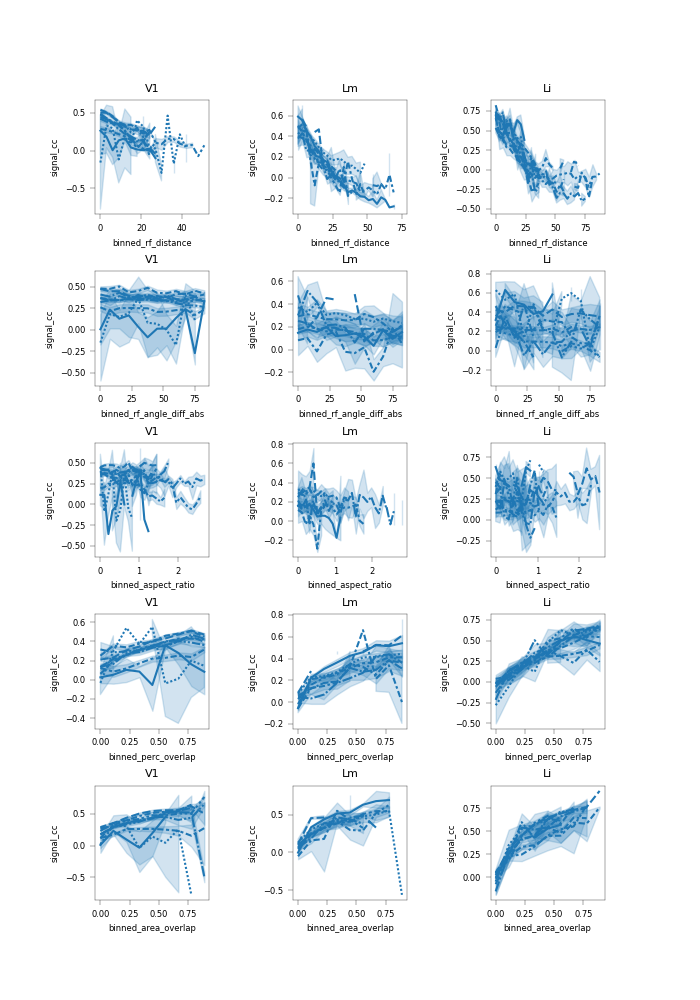

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [320]:
y_var = 'signal_cc'
y_var = 'signal_cc'

plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(len(plot_params),3, figsize=(7,10))
for ri, par in enumerate(plot_params):
    for va, vg in df.groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[ri, vi]
        ax.set_title(va)
        sns.lineplot(x='binned_%s' % par, y=y_var, ax=ax, data=vg,
                    style='datakey')
        ax.legend_.remove()
        ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, hspace=0.5, top=0.9)

In [ ]:
rf_angle_diff_abs

In [ ]:
# Calculate overlaps and distance (pairwise)
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
# Convert RF fit params to polygon
d_=[]
for (va, dk, exp), rfs_ in rfdata.groupby(['visual_area', 'datakey', 'experiment']):
    rois_ = rfs_['cell'].unique()
    if (va, dk, exp) not in pass_keys:
        continue      
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = get_rf_overlaps(rf_polys)
    rfs_.index = rfs_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(rfs_.loc[overlaps_['poly1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(rfs_.loc[overlaps_['poly2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    overlaps_['cortical_distance'] = dists
    overlaps_['visual_area'] = va
    overlaps_['datakey'] = dk
    overlaps_['experiment'] = exp
    d_.append(overlaps_)
overlaps = pd.concat(d_)
overlaps = overlaps.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})

## Overlap v. distance

In [ ]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 6

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    finaldf['binned_dist'], bin_edges = pd.qcut(finaldf['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    finaldf['binned_dist'], bin_edges = pd.cut(finaldf['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

In [235]:
meanf = finaldf.groupby(['visual_area', 'datakey', 'experiment', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


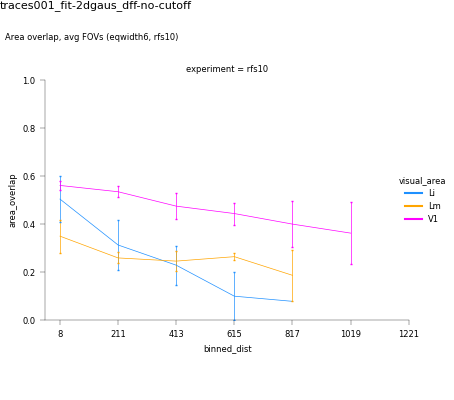

In [236]:
lw=0.5
metric='area_overlap'
fg = sns.relplot(x='binned_dist', y='area_overlap', hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                 err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Area overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


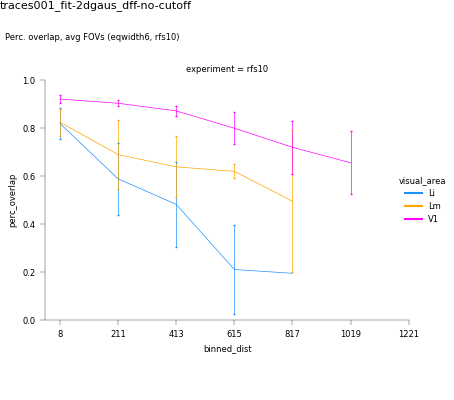

In [237]:
metric='perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Perc. overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


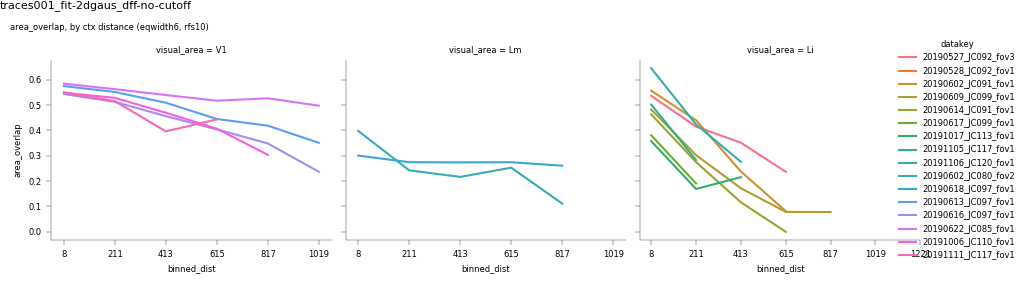

In [240]:
# fig, ax = pl.sublots()
metric = 'area_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


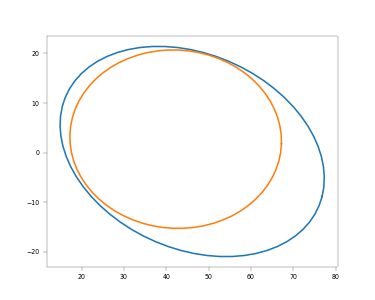

In [256]:
# fig, ax = pl.subplots()
# ax.plot(*rf_polys[4].exterior.xy)
# ax.plot(*rf_polys[11].exterior.xy)


In [ ]:
# # Convert stimuli to polyon bounding boxes
# stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
#               for blob_sz in stim_sizes[experiment]]